# Path Tracing Notebook
Implementation of Light Transport Algorithms

********************************************************************************************

In [1]:
import taichi as ti
ti.init(arch=ti.cpu, debug=True, random_seed=68739)

[Taichi] version 1.6.0, llvm 15.0.7, commit f1c6fbbd, osx, python 3.11.4


[I 02/20/25 08:55:57.230 60463823] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=arm64


In [2]:
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from taichi.math import vec3, cross, normalize, dot

In [3]:
from primitives.primitives import Triangle, Sphere, Primitive
from base.frame import Frame, frame_from_z
from base.materials import Material
from base.bsdf import BSDF
from primitives.ray import Ray
from base.lights import DiffuseAreaLight, UniformLightSampler
from base.camera import PerspectiveCamera

In [4]:
cornell_box = "../scenes/cornell-box.pbrt"
volumetric_caustic = "../scenes/volumetric-caustic.pbrt"
door_scene = "../scenes/veach/veach-ajar.pbrt"
testball ="../scenes/material-testball/scene-v4.pbrt"
one = "../scenes/one.pbrt"
cb = "../scenes/cb.pbrt"
veach_mis = "../scenes/veach-mis/scene-v4.pbrt"


file_path = veach_mis

In [5]:
from utils.pbrt_parser import parse_pbrt_lights_and_counts

lights_data, light_counts = parse_pbrt_lights_and_counts(file_path)

light_counts

{'total_lights': 3,
 'point': 0,
 'spot': 0,
 'distant': 0,
 'infinite': 0,
 'goniometric': 0,
 'projection': 0,
 'area': 3}

In [6]:
lights_data

[{'type': 'diffuse',
  'is_area': True,
  'from': [0.0, 0.0, 0.0],
  'to': [0.0, 0.0, 1.0],
  'I': [1.0, 1.0, 1.0],
  'L': (7.599088, 7.599088, 7.599088),
  'scale': 1.0,
  'power': 0.0,
  'illuminance': 0.0,
  'filename': '',
  'coneangle': 30.0,
  'conedeltaangle': 5.0,
  'twosided': False,
  'extra': {}},
 {'type': 'diffuse',
  'is_area': True,
  'from': [0.0, 0.0, 0.0],
  'to': [0.0, 0.0, 1.0],
  'I': [1.0, 1.0, 1.0],
  'L': (30.396353, 30.396353, 30.396353),
  'scale': 1.0,
  'power': 0.0,
  'illuminance': 0.0,
  'filename': '',
  'coneangle': 30.0,
  'conedeltaangle': 5.0,
  'twosided': False,
  'extra': {}},
 {'type': 'diffuse',
  'is_area': True,
  'from': [0.0, 0.0, 0.0],
  'to': [0.0, 0.0, 1.0],
  'I': [1.0, 1.0, 1.0],
  'L': (3039.6353, 3039.6353, 3039.6353),
  'scale': 1.0,
  'power': 0.0,
  'illuminance': 0.0,
  'filename': '',
  'coneangle': 30.0,
  'conedeltaangle': 5.0,
  'twosided': False,
  'extra': {}}]

In [7]:
from utils.pbrt_parser import parse_pbrt_materials

materials_data = parse_pbrt_materials(file_path)
len(materials_data)

6

In [8]:
materials_data

[{'name': 'Diffuse',
  'type': 'diffuse',
  'reflectance': (0.5, 0.5, 0.5),
  'transmittance': None,
  'eta': None,
  'k': None,
  'roughness': None,
  'uroughness': None,
  'vroughness': None,
  'remaproughness': None,
  'displacement': None,
  'normalmap': None,
  'filename': None,
  'scale': None,
  'medium': '',
  'tex_reflectance': '',
  'tex_filename': '',
  'emission': None},
 {'name': 'Smooth',
  'type': 'conductor',
  'reflectance': None,
  'transmittance': None,
  'eta': (0.200438, 0.924033, 1.102212),
  'k': (3.912949, 2.452848, 2.142188),
  'roughness': None,
  'uroughness': 0.01,
  'vroughness': 0.01,
  'remaproughness': False,
  'displacement': None,
  'normalmap': None,
  'filename': None,
  'scale': None,
  'medium': '',
  'tex_reflectance': '',
  'tex_filename': '',
  'emission': None},
 {'name': 'Glossy',
  'type': 'conductor',
  'reflectance': None,
  'transmittance': None,
  'eta': (0.200438, 0.924033, 1.102212),
  'k': (3.912949, 2.452848, 2.142188),
  'roughness':

In [9]:
from utils.pbrt_parser import parse_pbrt_file

shape_data, shape_counts, textures, mediums = parse_pbrt_file(file_path)

shape_counts

{'triangles': 52, 'spheres': 3}

In [12]:
from utils.pbrt_parser import update_light_materials

materials_data = update_light_materials(materials_data, lights_data)

In [13]:
materials_data

[{'name': 'Diffuse',
  'type': 'diffuse',
  'reflectance': (0.5, 0.5, 0.5),
  'transmittance': None,
  'eta': None,
  'k': None,
  'roughness': None,
  'uroughness': None,
  'vroughness': None,
  'remaproughness': None,
  'displacement': None,
  'normalmap': None,
  'filename': None,
  'scale': None,
  'medium': '',
  'tex_reflectance': '',
  'tex_filename': '',
  'emission': None},
 {'name': 'Smooth',
  'type': 'conductor',
  'reflectance': None,
  'transmittance': None,
  'eta': (0.200438, 0.924033, 1.102212),
  'k': (3.912949, 2.452848, 2.142188),
  'roughness': None,
  'uroughness': 0.01,
  'vroughness': 0.01,
  'remaproughness': False,
  'displacement': None,
  'normalmap': None,
  'filename': None,
  'scale': None,
  'medium': '',
  'tex_reflectance': '',
  'tex_filename': '',
  'emission': None},
 {'name': 'Glossy',
  'type': 'conductor',
  'reflectance': None,
  'transmittance': None,
  'eta': (0.200438, 0.924033, 1.102212),
  'k': (3.912949, 2.452848, 2.142188),
  'roughness':

In [12]:
from utils.pbrt_parser import populate_materials_field

n = len(materials_data)
materials_field = Material.field(shape=(n,))
populate_materials_field(materials_data, materials_field)
materials_field.shape, len(materials_data)

((6,), 6)

In [13]:
materials_field[8]

TaichiAssertionError: (kernel=snode_reader_3) Accessing field (S3place<f32>) of size (6) with indices (8)


In [14]:
shape_counts['triangles']+shape_counts['spheres']

55

In [15]:
from primitives.primitives import Primitive

# Create a Taichi field for the materials
n_primitives = shape_counts['triangles']+shape_counts['spheres']
PS = ti.root.dense(ti.i, n_primitives)
primitives = Primitive.field()
PS.place(primitives)

<ti.SNode of type dense>

In [16]:
from utils.pbrt_parser import build_materials_dict, create_primitives_field

# Build a dictionary mapping material names to Taichi Material objects.
materials_dict = build_materials_dict(materials_data)

# Create the primitives field (only triangles and spheres).
create_primitives_field(shape_data, materials_dict, primitives)

In [17]:
materials_dict

{'Diffuse': {'material_type': 0, 'color': [0.5, 0.5, 0.5], 'uroughness': 0.0, 'vroughness': 0.0, 'eta': 1.0, 'k': [0.0, 0.0, 0.0], 'emission': [0.0, 0.0, 0.0]},
 'Smooth': {'material_type': 2, 'color': [1.0, 1.0, 1.0], 'uroughness': 0.01, 'vroughness': 0.01, 'eta': 0.200438, 'k': [3.912949, 2.452848, 2.142188], 'emission': [0.0, 0.0, 0.0]},
 'Glossy': {'material_type': 2, 'color': [1.0, 1.0, 1.0], 'uroughness': 0.05, 'vroughness': 0.05, 'eta': 0.200438, 'k': [3.912949, 2.452848, 2.142188], 'emission': [0.0, 0.0, 0.0]},
 'Rough': {'material_type': 2, 'color': [1.0, 1.0, 1.0], 'uroughness': 0.1, 'vroughness': 0.1, 'eta': 0.200438, 'k': [3.912949, 2.452848, 2.142188], 'emission': [0.0, 0.0, 0.0]},
 'Null': {'material_type': 0, 'color': [0.0, 0.0, 0.0], 'uroughness': 0.0, 'vroughness': 0.0, 'eta': 1.0, 'k': [0.0, 0.0, 0.0], 'emission': [0.0, 0.0, 0.0]},
 'SuperRough': {'material_type': 2, 'color': [1.0, 1.0, 1.0], 'uroughness': 0.25, 'vroughness': 0.25, 'eta': 0.200438, 'k': [3.912949, 2.4

In [18]:
primitives.shape, shape_counts

((55,), {'triangles': 52, 'spheres': 3})

In [19]:
@ti.kernel
def do():
    for i in range(primitives.shape):
        if primitives[i].is_light == 1:
            print("hello")
            print(primitives[i].material.emission)

do()

/Users/dipanjan/LightTransportSimulator/lib/python3.11/site-packages/taichi/lang/ast/ast_transformer.py:59: Warning: Casting range_for boundary values from [Tensor (1) i32] to i32, which may cause numerical issues
  warnings.warn(


In [20]:
from base.lights import DiffuseAreaLight

# Create a Taichi field for light sources
n_lights = light_counts['area'] * 2
LS = ti.root.dense(ti.i, n_lights)
lights = DiffuseAreaLight.field()
LS.place(lights)

<ti.SNode of type dense>

In [21]:
if file_path == one:
    primitives[0].is_light = 1

In [22]:
primitives[0].material.uroughness

0.009999999776482582

In [23]:
lights_data

[{'type': 'diffuse',
  'is_area': True,
  'from': [0.0, 0.0, 0.0],
  'to': [0.0, 0.0, 1.0],
  'I': [1.0, 1.0, 1.0],
  'L': (7.599088, 7.599088, 7.599088),
  'scale': 1.0,
  'power': 0.0,
  'illuminance': 0.0,
  'filename': '',
  'coneangle': 30.0,
  'conedeltaangle': 5.0,
  'twosided': False,
  'extra': {}},
 {'type': 'diffuse',
  'is_area': True,
  'from': [0.0, 0.0, 0.0],
  'to': [0.0, 0.0, 1.0],
  'I': [1.0, 1.0, 1.0],
  'L': (30.396353, 30.396353, 30.396353),
  'scale': 1.0,
  'power': 0.0,
  'illuminance': 0.0,
  'filename': '',
  'coneangle': 30.0,
  'conedeltaangle': 5.0,
  'twosided': False,
  'extra': {}},
 {'type': 'diffuse',
  'is_area': True,
  'from': [0.0, 0.0, 0.0],
  'to': [0.0, 0.0, 1.0],
  'I': [1.0, 1.0, 1.0],
  'L': (3039.6353, 3039.6353, 3039.6353),
  'scale': 1.0,
  'power': 0.0,
  'illuminance': 0.0,
  'filename': '',
  'coneangle': 30.0,
  'conedeltaangle': 5.0,
  'twosided': False,
  'extra': {}}]

In [24]:
from base.bsdf import TrowbridgeReitzDistribution


@ti.kernel
def populate_shapes():
    light_idx = 0

    for i in range(primitives.shape[0]):

        primitives[i].bsdf.diffuse.type = 0
        primitives[i].bsdf.transmit.type = 1
        primitives[i].bsdf.dielectric.type = 2
        primitives[i].bsdf.conductor.type = 3
        primitives[i].bsdf.mirror.type = 4
        primitives[i].bsdf.specular.type = 5

        material = primitives[i].material

        if material.material_type==0:
            # Diffuse material
            primitives[i].bsdf.add_diffuse(material.color)
        elif material.material_type==1:
            # Dielectric material
            primitives[i].bsdf.add_dielectric(material.eta, material.color, material.uroughness, material.vroughness)
        elif material.material_type==2:
            # Conductor material
            primitives[i].bsdf.add_conductor(material.eta, material.k, material.uroughness, material.vroughness)

        if primitives[i].is_light == 1:
            primitives[i].light_idx = light_idx
            lights[light_idx].shape_idx = i  # Link the light to the primitive
            lights[light_idx].two_sided = 0  # Assuming lights are one-sided
            lights[light_idx].Le = primitives[i].material.emission
            light_idx += 1

populate_shapes()

In [31]:
lights_data[0]['L']

(7.599088, 7.599088, 7.599088)

In [33]:
primitives[lights[1].shape_idx].material.emission

[0. 0. 0.]

In [26]:
from primitives.aabb import AABB, BVHPrimitive

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
BS = ti.root.dense(ti.i, n_primitives)
bvh_primitives = BVHPrimitive.field()
BS.place(bvh_primitives)

scene_min = ti.Vector.field(3, dtype=ti.f32, shape=())  # Global min bounds
scene_max = ti.Vector.field(3, dtype=ti.f32, shape=())  # Global max bounds

@ti.kernel
def init_bounded_boxes():
    # Initialize scene bounding box with extreme values
    scene_min[None] = vec3(1e10, 1e10, 1e10)
    scene_max[None] = vec3(-1e10, -1e10, -1e10)

    for i in ti.ndrange(n_primitives):
        bvh_primitives[i].prim = primitives[i]
        bvh_primitives[i].prim_num = i

        # Get primitive bounds
        min_p, max_p = primitives[i].get_bounds()
        centroid = (min_p + max_p) * 0.5
        bvh_primitives[i].bounds = AABB(min_point=min_p, max_point=max_p, centroid=centroid)

        # Update scene-wide bounding box
        for j in range(3):  # Loop over x, y, z components
            scene_min[None][j] = min(scene_min[None][j], min_p[j])
            scene_max[None][j] = max(scene_max[None][j], max_p[j])


init_bounded_boxes()

bvh_primitives.shape[0], n_primitives

(36, 36)

In [27]:
bvh_primitives[5].prim

{'shape_type': <taichi.lang.field.SNodeHostAccess object at 0x11c11fdd0>, 'triangle': {'vertex_1': [-1.0, -1.0, 7.800000190734863], 'vertex_2': [1.0, 1.0, 7.800000190734863], 'vertex_3': [1.0, -1.0, 7.800000190734863], 'centroid': [0.3333333432674408, -0.3333333432674408, 7.800000190734863], 'normal': [8.742279788975793e-08, -4.3711398944878965e-08, 1.0], 'edge_1': [2.0, 2.0, 0.0], 'edge_2': [2.0, 0.0, 0.0]}, 'sphere': {'center': [0.0, 0.0, 0.0], 'radius': <taichi.lang.field.SNodeHostAccess object at 0x11c11e990>}, 'material': {'material_type': <taichi.lang.field.SNodeHostAccess object at 0x11c11ed10>, 'color': [0.7250000238418579, 0.7099999785423279, 0.6800000071525574], 'uroughness': <taichi.lang.field.SNodeHostAccess object at 0x11c11f8d0>, 'vroughness': <taichi.lang.field.SNodeHostAccess object at 0x11c11d510>, 'eta': <taichi.lang.field.SNodeHostAccess object at 0x11c11ddd0>, 'k': [0.0, 0.0, 0.0], 'emission': [0.0, 0.0, 0.0]}, 'bsdf': {'type': <taichi.lang.field.SNodeHostAccess obj

In [28]:
# bounded_boxes[3]

In [29]:
OPS = ti.root.dense(ti.i, n_primitives)
ordered_prims = Primitive.field()
OPS.place(ordered_prims)

<ti.SNode of type dense>

In [30]:
from accelerators.bvh import BVHNode, BucketInfo

node_idx = 0

BVS = ti.root.dense(ti.i, 3 * n_primitives)
nodes = BVHNode.field()
BVS.place(nodes)


<ti.SNode of type dense>

In [31]:
nodes.shape[0]

108

In [32]:
total_nodes = ti.field(ti.i32, shape=())
split_method = ti.field(ti.i32, shape=())
start = ti.field(ti.i32, shape=())
end = ti.field(ti.i32, shape=())
ordered_prims_idx = ti.field(ti.i32, shape=())
stack_ptr = ti.field(ti.i32, shape=())
# ordered_prims_size = ti.field(ti.i32, shape=())

@ti.kernel
def init_stack():
    total_nodes[None] = 0
    split_method[None] = 0
    start[None] = 0
    end[None] = n_primitives
    ordered_prims_idx[None] = 0
    stack_ptr[None] = 0
    # ordered_prims_size[None] = 0

init_stack()

In [33]:
stack = ti.field(ti.i32, shape=(3*n_primitives, 4))
n_buckets = 12
buckets = BucketInfo.field(shape=(n_buckets))
costs = ti.field(dtype=ti.f32, shape=(n_buckets-1))

In [34]:
from accelerators.bvh import build_bvh

start_t = time.time()

build_bvh(primitives, bvh_primitives, start, end, ordered_prims, nodes, total_nodes, split_method, stack, stack_ptr, ordered_prims_idx, costs, buckets)

end_t = time.time()

In [35]:
# total_nodes = ti.field(ti.i32, shape=())
# split_method = ti.field(ti.i32, shape=())
# start = ti.field(ti.i32, shape=())
# end = ti.field(ti.i32, shape=())
# ordered_prims_idx = ti.field(ti.i32, shape=())
# stack_ptr = ti.field(ti.i32, shape=())
# max_prims_in_node = ti.field(ti.i32, shape=())
# # ordered_prims_size = ti.field(ti.i32, shape=())
#
# @ti.kernel
# def init_stack():
#     total_nodes[None] = 0
#     split_method[None] = 0
#     start[None] = 0
#     end[None] = n_primitives
#     ordered_prims_idx[None] = 0
#     stack_ptr[None] = 0
#     max_prims_in_node[None] = 4
#
# init_stack()

In [36]:
# stack = ti.field(ti.i32, shape=(3*n_primitives, 4))
# n_buckets = 12
# buckets = BucketInfo.field(shape=(n_buckets))
# costs = ti.field(dtype=ti.f32, shape=(n_buckets-1))

In [37]:
# from accelerators.hlbvh import build_hlbvh
# from accelerators.bvh import build_bvh
#
# start_t = time.time()
#
# root = ti.field(ti.i32, shape=())
#
# build_hlbvh(
#     primitives,
#     bvh_primitives,
#     ordered_prims,
#     n_primitives,       # number of actual primitives
#     nodes,
#     total_nodes,
#     ordered_prims_idx,  # you already have this
#     max_prims_in_node,
#     root
# )
#
# end_t = time.time()

In [38]:
print("Elapsed (with compilation) = %s" % (end_t - start_t))
print(f"Total Nodes: {total_nodes}")

Elapsed (with compilation) = 3.3990752696990967
Total Nodes: 57


In [39]:
from tests.test_bvh import print_bvh

print_bvh(nodes, total_nodes[None])

BVHNode 0 [Interior]: split_axis = 1 child_0 = 1 child_1 = 30 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
BVHNode 1 [Interior]: split_axis = 1 child_0 = 2 child_1 = 13 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
BVHNode 2 [Interior]: split_axis = 1 child_0 = 3 child_1 = 6 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
BVHNode 3 [Interior]: split_axis = 1 child_0 = 4 child_1 = 5 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
BVHNode 4 [Leaf]: first_prim_offset = 0 n_primitives = 2 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, -1.000000, 7.800000] )
BVHNode 5 [Leaf]: first_prim_offset = 2 n_primitives = 2 bounds = (min: [-1.000000, 1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
BVHNode 6 [Interior]: split_axis = 0 child_0 = 7 child_1 = 8 bounds = (min: [-1.000000, -1.000000, 5.800000] , m

In [40]:
from tests.test_bvh import test_bvh
max_nodes = n_primitives
debug_stack = ti.field(dtype=ti.i32, shape=(max_nodes,))
debug_ptr = ti.field(dtype=ti.i32, shape=(1,))
error_count = ti.field(dtype=ti.i32, shape=(1,))

test_bvh(nodes, debug_stack, debug_ptr, error_count)

BVH test error count = 0


In [41]:
from accelerators.bvh import LinearBVHNode
from accelerators.bvh import flatten_bvh

# create a linear representation of the bvh tree (empty)

LBVS = ti.root.dense(ti.i, total_nodes[None])
linear_bvh = LinearBVHNode.field()
LBVS.place(linear_bvh)

stack_size = 2 * n_primitives - 1  # Maximum possible stack size
stack3 = ti.Vector.field(3, dtype=ti.i32, shape=stack_size)
stack_top_2 = ti.field(dtype=ti.i32, shape=())

start_t = time.time()
total_nodes = flatten_bvh(nodes, linear_bvh, 0, stack3, stack_top_2)
end_t = time.time()
print(f"Total flattened nodes: {total_nodes}")

Total flattened nodes: 57


In [42]:
linear_bvh[0].second_child_offset

30

In [43]:
print("Elapsed (with compilation) = %s" % (end_t - start_t))

Elapsed (with compilation) = 0.09395885467529297


In [44]:
from tests.test_linear_bvh import print_flattened_bvh

print_flattened_bvh(linear_bvh, total_nodes)

LinearBVHNode 0 [Interior]: axis = 1 second_child_offset = 30 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
LinearBVHNode 1 [Interior]: axis = 1 second_child_offset = 13 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
LinearBVHNode 2 [Interior]: axis = 1 second_child_offset = 6 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
LinearBVHNode 3 [Interior]: axis = 1 second_child_offset = 5 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
LinearBVHNode 4 [Leaf]: primitives_offset = 0 n_primitives = 2 bounds = (min: [-1.000000, -1.000000, 5.800000] , max: [1.000000, -1.000000, 7.800000] )
LinearBVHNode 5 [Leaf]: primitives_offset = 2 n_primitives = 2 bounds = (min: [-1.000000, 1.000000, 5.800000] , max: [1.000000, 1.000000, 7.800000] )
LinearBVHNode 6 [Interior]: axis = 0 second_child_offset = 8 bounds = (min: [-1.000000, -1.000000, 5

In [45]:
from tests.test_linear_bvh import test_flattened_bvh

max_nodes = n_primitives
debug_stack = ti.field(dtype=ti.i32, shape=(max_nodes,))
debug_ptr = ti.field(dtype=ti.i32, shape=(1,))
error_count = ti.field(dtype=ti.i32, shape=(1,))

test_flattened_bvh(linear_bvh, debug_stack, debug_ptr, error_count)

Flattened BVH test error count = 0


In [46]:
from utils.pbrt_parser import parse_camera_from_file
camera_data = parse_camera_from_file(file_path)
camera_data

{'type': 'perspective',
 'shutteropen': 0.0,
 'shutterclose': 1.0,
 'frameaspectratio': None,
 'screenwindow': None,
 'lensradius': 0.0,
 'focaldistance': 1e+30,
 'fov': 19.5,
 'mapping': 'equalarea',
 'lensfile': '',
 'aperturediameter': 1.0,
 'focusdistance': 10.0,
 'aperture': None,
 'near': 0.1,
 'far': 1000.0,
 'position': (0.0, 0.0, 0.0),
 'target': (0.0, 0.0, -1.0),
 'up': (0.0, 1.0, 0.0),
 'transform': (1.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  1.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -1.0,
  -0.0,
  -0.0,
  -1.0,
  6.8,
  1.0)}

In [47]:
camera_data['lensradius']

0.0

In [48]:
import taichi as ti
from taichi.math import (
    vec3, length, normalize, cross, radians, sin, tan, dot
)
from base.frame import create_frame
from base.camera import PerspectiveCamera

scene_min = ti.Vector.field(3, dtype=ti.f32, shape=())
scene_max = ti.Vector.field(3, dtype=ti.f32, shape=())

@ti.func
def frame_look_at(eye, center, up):
    """
    PBRT v4-like LookAt:
      - +Z = forward = (center - eye)
      - +X = right
      - +Y = up
    If forward or cross products degenerate, picks a fallback.
    """
    forward_raw = center - eye
    if length(forward_raw) < 1e-8:
        forward_raw = vec3(0, 0, 1)
    forward = normalize(forward_raw)

    up_len = length(up)
    if up_len < 1e-8:
        up = vec3(0, 1, 0)
        up_len = 1.0
    up_n = up / up_len

    # If up is nearly parallel to forward, pick fallback
    dot_uf = ti.abs(dot(up_n, forward))
    if dot_uf > 0.9999:
        fallback = vec3(0, 1, 0)
        if ti.abs(dot(fallback, forward)) > 0.9999:
            fallback = vec3(1, 0, 0)
        up_n = normalize(fallback)

    # PBRT style: z = forward, x = cross(up, z), y = cross(z, x)
    z = forward
    x_raw = cross(up_n, z)
    if length(x_raw) < 1e-8:
        x_raw = vec3(1, 0, 0)
    x = normalize(x_raw)
    y = cross(z, x)
    return create_frame(x, y, z)

@ti.kernel
def create_perspective_camera(film_width: int, film_height: int) -> PerspectiveCamera:
    """
    Auto-fit a perspective camera so [scene_min, scene_max] is fully visible.
    +Z looks from camera to scene center. +Y is 'up'.
    """
    fov_degrees = float(camera_data.get('fov', 45.0))
    lens_radius = 0.0
    focal_distance = 1e3
    world_up = vec3(0, 1, 0)

    # You can tweak distance_scale or fov_degrees to zoom in/out
    distance_scale = 0.01

    # 1) Bounding sphere
    c = 0.5 * (scene_min[None] + scene_max[None])
    diag = scene_max[None] - scene_min[None]
    r = 0.5 * length(diag)
    if r < 1e-8:
        r = 1.0

    # 2) Distance so sphere fits in FOV
    half_fov = radians(0.5 * fov_degrees)
    dist = (r / sin(half_fov)) * distance_scale

    # 3) Eye = center - dist*(0,0,1)
    eye = c - dist * vec3(0, 0, 1)

    # 4) Frame from PBRT-like LookAt
    cam_frame = frame_look_at(eye, c, world_up)

    # 5) Film plane setup @ z=1 => half-height = tan(half_fov)
    aspect = film_width / film_height
    screen_height = 2.0 * tan(half_fov)
    screen_width  = aspect * screen_height

    # Differentials.
    # If your final image is upside down, you can flip 'dy_c' or invert 't' in generate_ray()
    dx_c = vec3(screen_width / film_width, 0.0, 0.0)
    dy_c = vec3(0.0,  screen_height / film_height, 0.0)
    # (No minus sign here; we'll handle flips in generate_ray if needed.)

    cam = PerspectiveCamera(
        width         = film_width,
        height        = film_height,
        position      = eye,
        frame         = cam_frame,
        fov           = fov_degrees,
        aspect_ratio  = aspect,
        lens_radius   = lens_radius,
        focal_distance= focal_distance,
        screen_dx     = screen_width,
        screen_dy     = screen_height,
        dx_camera     = dx_c,
        dy_camera     = dy_c
    )
    return cam

# Example usage:
# scene_min[None] = [...]
# scene_max[None] = [...]
camera = create_perspective_camera(400, 400)


/var/folders/wh/k56cqfld3sb6mcx2fr_1w3rm0000gn/T/ipykernel_82109/1696806649.py:54: UserWarning: Calling non-taichi function "camera_data.get". Scope inside the function is not processed by the Taichi AST transformer. The function may not work as expected. Proceed with caution! Maybe you can consider turning it into a @ti.func?
  fov_degrees = float(camera_data.get('fov', 45.0))


In [49]:
# import taichi as ti
# from taichi.math import vec3, normalize, cross, radians, tan
# from base.camera import PerspectiveCamera
# from base.frame import Frame  # your Frame class
#
# width = 400
# height = 400
#
# # Global camera field
# camera = PerspectiveCamera.field(shape=())
#
# @ti.kernel
# def initialize_camera():
#     obj_min = scene_min[None]
#     obj_max = scene_max[None]
#     center  = 0.5 * (obj_min + obj_max)
#     extent  = obj_max - obj_min
#     local_rad = 0.5 * ti.max(extent.x, ti.max(extent.y, extent.z))
#
#     print(obj_min, obj_max, center)
#
#     fov_degrees = 60.0 #float(camera_data.get('fov', 45.0))
#     fov_rad = radians(fov_degrees)
#
#     d = local_rad / tan(0.5 * fov_rad) + local_rad
#     pos = center - vec3(0.0, 1.0, d)
#
#     forward = normalize(center - pos)
#
#     camera[None].width = width
#     camera[None].height = height
#     camera[None].position = pos - vec3([0, 0, 2.5])
#
#     camera[None].frame = frame_from_z(forward)
#
#     camera[None].fov = fov_degrees
#     aspect_ratio = width / float(height)
#     camera[None].aspect_ratio = aspect_ratio
#     camera[None].lens_radius = float(camera_data.get('lensradius', 0.0))
#     camera[None].focal_distance = d
#
#     screen_dy = 2.0 * tan(0.5 * fov_rad)
#     screen_dx = screen_dy * aspect_ratio
#     camera[None].screen_dx = screen_dx
#     camera[None].screen_dy = screen_dy
#     camera[None].dx_camera = vec3([screen_dx / width, 0.0, 0.0])
#     camera[None].dy_camera = vec3([0.0, screen_dy / height, 0.0])
#
#
# initialize_camera()


In [50]:
camera

{'width': 400, 'height': 400, 'position': [0.0, 0.0, -0.05904947593808174], 'frame': {'x': [1.0, 0.0, -0.0], 'y': [-0.0, 1.0, 0.0], 'z': [0.0, 0.0, 1.0]}, 'fov': 19.5, 'aspect_ratio': 1.0, 'lens_radius': 0.0, 'focal_distance': 1000.0, 'screen_dx': 0.3436628580093384, 'screen_dy': 0.3436628580093384, 'dx_camera': [0.000859157124068588, 0.0, 0.0], 'dy_camera': [0.0, 0.000859157124068588, 0.0]}

In [51]:
scene_min[None], scene_max[None]

([0. 0. 0.], [0. 0. 0.])

In [52]:
camera.frame

{'x': [1.0, 0.0, -0.0], 'y': [-0.0, 1.0, 0.0], 'z': [0.0, 0.0, 1.0]}

In [53]:
@ti.kernel
def test_camera():
    # Generate a ray
    s, t = 0.5, 0.5  # Center of the screen
    ray_origin, ray_dir, rx_origin, rx_dir, ry_origin, ry_dir = camera.generate_ray_differential(s, t)
    print(ray_origin, ray_dir, rx_origin, rx_dir, ry_origin, ry_dir)

test_camera()

[0.000000, 0.000000, -0.059049] [0.000000, 0.000000, 1.000000] [0.000000, 0.000000, -0.059049] [0.000859, 0.000000, 1.000000] [0.000000, 0.000000, -0.059049] [0.000000, 0.000859, 1.000000]


In [54]:
from base.scene import Scene

pt = 0
mis = 1

# Instantiate a Scene object with the Camera object
scene = Scene(integrator=pt, spp=64, max_depth=6, sample_lights=1, sample_bsdf=1)

In [55]:
from base.render import render

# Initialize the image field outside the kernel using the actual values
image = ti.Vector.field(3, dtype=ti.f32, shape=(camera.width, camera.height))


start_t = time.time()

# Call the render_scene kernel
render(scene, image, lights, camera, ordered_prims, linear_bvh)

end_t = time.time()

print("Elapsed (with compilation) = %s" % (end_t - start_t))

Elapsed (with compilation) = 45.680134773254395


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


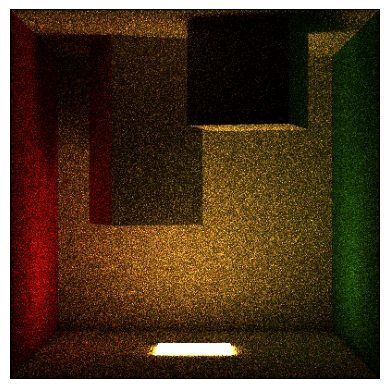

In [56]:
image_np = image.to_numpy()
# if np.isnan(image_np).any() or np.isinf(image_np).any():
#     print("Warning: NaN or Inf values detected in the image")
# image_np = np.clip(image_np, 0, 1)  # Clip values between 0 and 1
plt.imshow(image_np)
plt.axis('off')
plt.show()

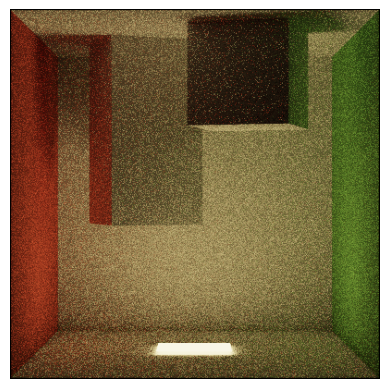

In [57]:
def tone_mapping(hdr_image, gamma=2.2):
    ldr_image = hdr_image / (1.0 + hdr_image)
    ldr_image = np.power(ldr_image, 1.0 / gamma)
    return np.clip(ldr_image, 0, 1)

ldr_image = tone_mapping(image_np)

# Display the tone-mapped image
plt.imshow(ldr_image)
plt.axis('off')
plt.show()

In [53]:
r

NameError: name 'r' is not defined